In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tomllib
from stable_baselines3 import PPO

from envs.exec_env import ExecutionEnv
from baselines.twap_vwap import twap_schedule
from baselines.almgren_chriss import almgren_chriss_linear
from eval.metrics import implementation_shortfall

### Load Trained Model

In [10]:
MODELS_DIR = Path(os.getenv('MODELS_DIR', './lab/rl/models'))
CONFIGS_DIR = Path(os.getenv('CONFIGS_DIR', './lab/rl/experiments'))

model = PPO.load(MODELS_DIR / 'exec_ppo_final.zip')
configs = tomllib.load((CONFIGS_DIR / 'exec_reward_ablation.toml').open('rb'))
env = ExecutionEnv(configs)

### Evaluate multiple episodes

In [12]:
results = []
for seed in range(10):
    obs, _ = env.reset(seed=seed)
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
    paid = -env.cash
    ideal = env.mid_hist[0] * env.init_inventory
    IS = implementation_shortfall(paid, ideal)
    results.append(IS)
print(f"Mean IS: {np.mean(results):.2f} ± {np.std(results):.2f}")

Mean IS: -49.89 ± 0.00


### Compare baselines

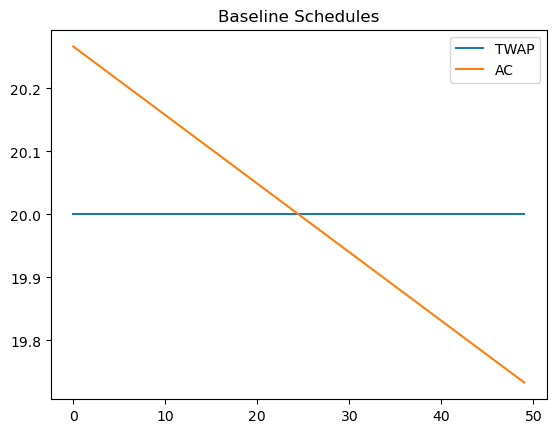

In [13]:
T = 50
q0 = env.init_inventory
twap = twap_schedule(T, q0)
ac = almgren_chriss_linear(T, q0)
plt.plot(twap, label="TWAP")
plt.plot(ac, label="AC")
plt.title("Baseline Schedules")
plt.legend()
plt.show()

### Plot IS Distribution

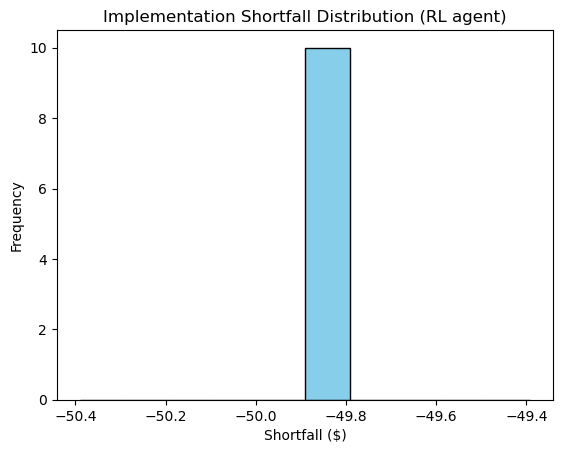

In [14]:
plt.hist(results, bins=10, color='skyblue', edgecolor='k')
plt.title("Implementation Shortfall Distribution (RL agent)")
plt.xlabel("Shortfall ($)")
plt.ylabel("Frequency")
plt.show()